# Network analysis 2020 project

## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import collections
import math
import json
from networkx.algorithms import community

## Read data

* [Real Datasets for Spatial Databases: Road Networks and Points of Interest
Dataset](https://www.cs.utah.edu/~lifeifei/SpatialDataset.htm) / 4. City of San Joaquin County (TG) Road Network
    * TG Road Network's Nodes (Node ID, Normalized X Coordinate, Normalized Y Coordinate)  
    * TG Road Network's Edges (Edge ID, Start Node ID, End Node ID, L2 Distance)
* [San Joaquin County, CA
Geographic Information Systems](http://www.sjmap.org/GISDataDownload.htm) / GIS Data Download
    * Points Of Interest
    * Streets

In [2]:
edges = pd.read_csv('TG.cedge', names=["edge_id", "start_node_id", "end_node_id", "l2_distance"], sep=" ")
G = nx.from_pandas_edgelist(edges, "start_node_id", "end_node_id", edge_attr=True)
nodes = pd.read_csv('TG.cnode', names=["node_id", "x_coordinate", "y_coordinate"], sep=" ")
data = nodes.set_index('node_id').to_dict('index').items()
G.add_nodes_from(data)

print("Nodes count: {}".format(len(G.nodes())))
print("Edges count: {}".format(len(G.edges())))

crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
points_of_interest = gpd.read_file("PointsOfInterest/PointsOfInterest.shp")
points_of_interest = points_of_interest.to_crs(crs)
points_of_interest = points_of_interest[points_of_interest.geometry.x < -120] # Falsy points "POINT (165.9984561648179 -90)"
streets = gpd.read_file("Streets/Streets.shp")
streets = streets.to_crs(crs)

print("Points of interest count: {}".format(len(points_of_interest)))

Nodes count: 18263
Edges count: 23797
Points of interest count: 1507


## Merge and plot graphs

In [69]:
# Parameters
x_fix=-121.58
y_fix=37.555
scale_x=0.000066
scale_y=0.000072

# Functions
def transform_x_coord(x, x_fix, scale_x):
    return x*scale_x + x_fix

def transform_y_coord(y, y_fix, scale_y):
    return y*-1*scale_y + y_fix + 10000*scale_y

def draw_scatter_nodes(scatter_nodes, x_fix=0.0, y_fix=0.0, scale_x=1.0, scale_y=1.0):
    scatter_x = []
    scatter_y = []
    for nodeIndex in scatter_nodes:
        node = G.nodes[nodeIndex]
        scatter_x.append(transform_x_coord(node["x_coordinate"], x_fix, scale_x))
        scatter_y.append(transform_y_coord(node["y_coordinate"], y_fix, scale_y))
    
    plt.scatter(scatter_x, scatter_y, alpha=0.5, s=2)

def draw_road_graph(graph, min_edge_length=80, figure=None, figsize=(10,8), dpi=100, x_fix=0.0, y_fix=0.0, scale_x=1.0, scale_y=1.0):
    if not figure:
        plt.figure(figsize=figsize, dpi=dpi)
    for edge in G.edges(data=True):
        edge_data = edge[2]
        if edge_data["l2_distance"] < min_edge_length:
            continue;
        start_node = G.nodes[edge[0]]
        end_node = G.nodes[edge[1]]
        x_coordinates = [transform_x_coord(start_node["x_coordinate"], x_fix, scale_x), transform_x_coord(end_node["x_coordinate"], x_fix, scale_x)]
        y_coordinates = [transform_y_coord(start_node["y_coordinate"], y_fix, scale_y), transform_y_coord(end_node["y_coordinate"], y_fix, scale_y)]
        plt.plot(x_coordinates, y_coordinates, 'k-', lw=1)

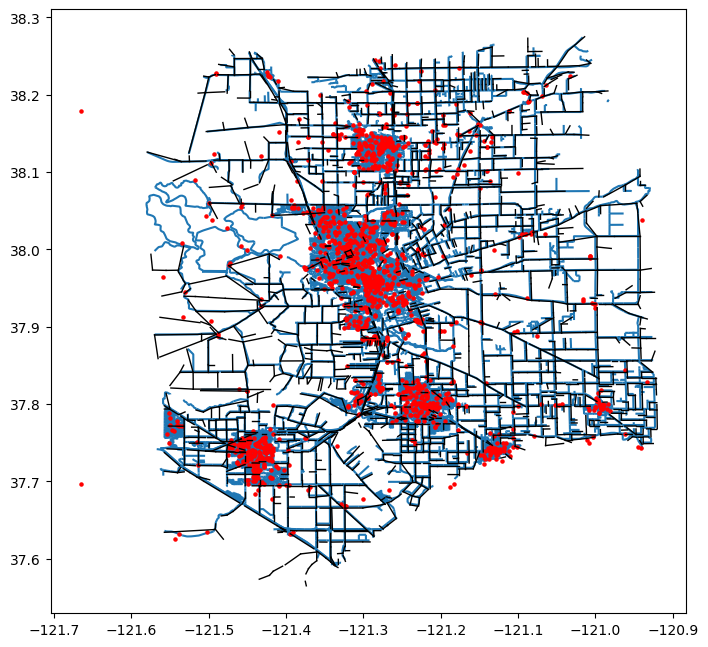

In [70]:
# Plot graphs
fig, ax = plt.subplots(figsize=(10,8), dpi=100)
ax.set_aspect('equal')
points_of_interest.plot(ax=ax, color="red", markersize=5, zorder=2)
streets.plot(ax=ax, zorder=1)
draw_road_graph(G, x_fix=x_fix, y_fix=y_fix, figure=fig, scale_x=scale_x, scale_y=scale_y)

## Degree distribution

Degrees: [4, 1, 3, 2, 5, 6, 8]
Degree frequency: [3385, 3417, 7540, 3868, 41, 10, 2]


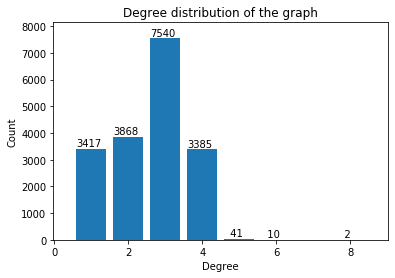

In [4]:
nodes, degrees = map(list, zip(*G.degree()))
count = collections.Counter(degrees)

x, y = map(list, zip(*count.items()))
print('Degrees: {}'.format(x))
print('Degree frequency: {}'.format(y))

fig, ax = plt.subplots()
plt.margins(x=0.08, y=0.08)
plt.bar(x,y)
plt.title('Degree distribution of the graph')
plt.xlabel('Degree')
plt.ylabel('Count')

for degree, freq in zip(x, y):
    ax.text(degree - .4, freq + 100, " "*(4-len(str(freq))) + str(freq), color='black')

## Computing number of nearest poi:s for each node

* This can be pretty slow ~5min.
* First code block counts the nearest poi:s for the nodes and dumps the result map (node to count) to json file. Also adds the 'near_poi_count' attribute to the nodes in the graph (G).
* Second code block just reads the json dump (node to count map) and adds the 'near_poi_count' attribute to the nodes in the graph.

In [14]:
near_poi_count = {}
for node in G.nodes():
    near_poi_count[node] = 0
    
poi_x = points_of_interest.geometry.x
poi_y = points_of_interest.geometry.y
poi_coor = list(zip(poi_x, poi_y))
    
for coor in poi_coor:
    nearest_node_dist = np.inf
    nearest_node = np.NAN
    for node in G.nodes(data=True):
        attributes = node[1]
        x = transform_x_coord(attributes["x_coordinate"], x_fix, scale_x)
        y = transform_y_coord(attributes["y_coordinate"], y_fix, scale_y)
        current_node_dist = math.sqrt((x - coor[0])**2 + (y - coor[1])**2)
        if current_node_dist < 0.05:
            near_poi_count[node[0]] += 1
    

with open('near_poi_count.json', 'w') as file:
    json.dump(near_poi_count, file)
    
nx.set_node_attributes(G, near_poi_count, 'near_poi_count')

In [15]:
with open('near_poi_count.json') as file:
    near_poi_count = json.load(file)
    near_poi_count = {int(k):int(v) for k,v in near_poi_count.items()}
nx.set_node_attributes(G, near_poi_count, 'near_poi_count')

## Community detection

Uses Clauset-Newman-Moore greedy modularity maximization. See [documentation](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html).

The communities are ordered by the average near_poi_count of their nodes. The top communities are drawn on the map.

In [25]:
communities = list(community.greedy_modularity_communities(G))

In [39]:

def get_average_poi_count(node_list):
    average_poi_count = 0
    for node in G.subgraph(node_list).nodes(data=True):
        average_poi_count += node[1]['near_poi_count']
    return average_poi_count / len(node_list)


poi_to_community_dict = {}
for i in range(len(communities)):
    average_poi_count = get_average_poi_count(communities[i])
    poi_to_community_dict[average_poi_count] = i

sorted_poi_count_list = sorted(poi_to_community_dict.keys(), reverse=True)

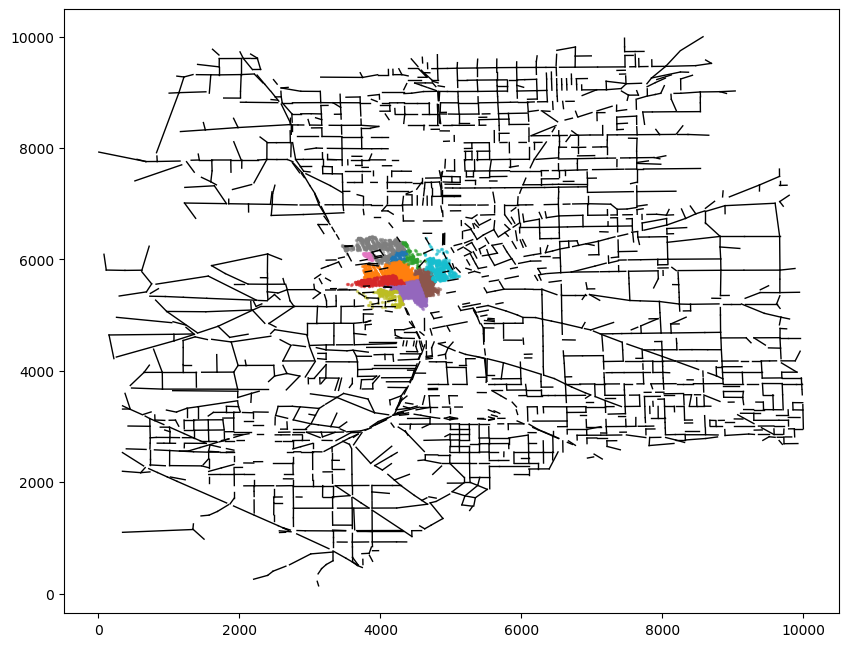

In [80]:
number_of_communities = 10

fig, ax = plt.subplots(figsize=(10,8), dpi=100)
draw_road_graph(G, figure=fig)

for i in range(number_of_communities):
    index = poi_to_community_dict[sorted_poi_count_list[i]]
    draw_scatter_nodes(scatter_nodes=communities[index])
    